# Aircraft Keypoint Detection from Satellite Images
---
Phase 2

In [2]:
import pandas as pd
import numpy as np
import json

import PIL

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as patches

import cv2

## Convert annotations in geo coordinates (lat-long) to pixel coor

In [3]:
# read all geojson files from geojson_aircraft_tiled folder
import os

test_geojson_files = os.listdir('/kaggle/input/rareplane-dataset/test/geojson_aircraft_tiled')
temp_json = json.load(open(f'/kaggle/input/rareplane-dataset/test/geojson_aircraft_tiled/{test_geojson_files[0]}'))
print(temp_json['features'][0]['properties'].keys())
print(temp_json['features'][0]['geometry'].keys())

dict_keys(['loc_id', 'cat_id', 'location', 'role', 'role_id', 'is_plane', 'num_engines', 'propulsion', 'canards', 'num_tail_fins', 'wing_position', 'wing_type', 'length', 'wingspan', 'area', 'faa_wingspan_class', 'Public_Train', 'Public_Test', 'partialDec', 'truncated', 'new_area'])
dict_keys(['type', 'coordinates'])


In [4]:
COLUMNS = ['file_name', 'geotransform'] + list(temp_json['features'][0]['properties'].keys()) + list(temp_json['features'][0]['geometry'].keys()) 
COLUMNS

['file_name',
 'geotransform',
 'loc_id',
 'cat_id',
 'location',
 'role',
 'role_id',
 'is_plane',
 'num_engines',
 'propulsion',
 'canards',
 'num_tail_fins',
 'wing_position',
 'wing_type',
 'length',
 'wingspan',
 'area',
 'faa_wingspan_class',
 'Public_Train',
 'Public_Test',
 'partialDec',
 'truncated',
 'new_area',
 'type',
 'coordinates']

In [5]:
import xml.etree.ElementTree as ET

def get_geo_transform(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    geo_transform = root.find(".//GeoTransform").text
    # to list of float
    geo_transform = [float(i) for i in geo_transform.split(",")]
    return geo_transform

xml_file = '/kaggle/input/rareplane-dataset/test/PS-RGB_tiled/105_104001003108D900_tile_47.png.aux.xml'
geo_transform = get_geo_transform(xml_file)
print(geo_transform)

[-142.95746726110332, 3.030316891760191e-06, 0.0, 63.329655251255616, 0.0, -3.030316891760191e-06]


In [6]:
# load all geojson files into a dataframe
test_annotations_df = pd.DataFrame(columns=COLUMNS)
for geojson_file in test_geojson_files:
    temp_json = json.load(open(f'/kaggle/input/rareplane-dataset/test/geojson_aircraft_tiled/{geojson_file}', "r"))
    temp_xml = '/kaggle/input/rareplane-dataset/test/PS-RGB_tiled/' + geojson_file.replace('.geojson', '.png.aux.xml')
    temp_geo_transform = get_geo_transform(temp_xml)
    
    for feature in temp_json['features']:
        test_annotations_df = pd.concat([test_annotations_df, 
                                          pd.DataFrame([[geojson_file, temp_geo_transform] 
                                                        + list(feature['properties'].values()) 
                                                        + list(feature['geometry'].values())]
                                                       , columns=COLUMNS)])

test_annotations_df.head()

/tmp/ipykernel_42/1723610284.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_annotations_df = pd.concat([test_annotations_df,


,file_name,geotransform,loc_id,cat_id,location,role,role_id,is_plane,num_engines,propulsion,...,wingspan,area,faa_wingspan_class,Public_Train,Public_Test,partialDec,truncated,new_area,type,coordinates
0,67_1040010046D15B00_tile_774.geojson,"[-111.98214645801923, 2.829693144976493e-06, 0...",67,1040010046D15B00,"Salt Lake City International Airport, Drop Off...",Medium Civil Transport/Utility,2,1,2,jet,...,34.306997,671.321942,3,0,1,1.000000,0,671.321942,Polygon,"[[[-111.98183989657028, 40.79378356375543], [-..."
0,67_1040010046D15B00_tile_774.geojson,"[-111.98214645801923, 2.829693144976493e-06, 0...",67,1040010046D15B00,"Salt Lake City International Airport, Drop Off...",Medium Civil Transport/Utility,2,1,2,jet,...,34.292199,676.388139,3,0,1,1.000000,0,676.388139,Polygon,"[[[-111.98128715518881, 40.79382686607564], [-..."
0,115_104001004B8E2D00_tile_710.geojson,"[-86.75294525769425, 2.823976593171725e-06, 0....",115,104001004B8E2D00,Birmingham-Shuttlesworth International Airport...,Military Transport/Utility/AWAC,4,1,4,jet,...,39.838210,778.004077,4,0,1,0.990560,1,770.659352,Polygon,"[[[-86.75294525769425, 33.56940275114304], [-8..."
0,115_104001004B8E2D00_tile_710.geojson,"[-86.75294525769425, 2.823976593171725e-06, 0....",115,104001004B8E2D00,Birmingham-Shuttlesworth International Airport...,Military Transport/Utility/AWAC,4,1,4,jet,...,39.836713,829.941651,4,0,1,0.374293,1,310.641720,Polygon,"[[[-86.75252053891688, 33.569193095837484], [-..."
0,77_104001004299B200_tile_754.geojson,"[-84.43094123114106, 3.0542719660063734e-06, 0...",77,104001004299B200,Hartsfield–Jackson Atlanta International Airpo...,Medium Civil Transport/Utility,2,1,2,jet,...,31.764429,703.382228,3,0,1,1.000000,0,703.382228,Polygon,"[[[-84.43061480993161, 33.65122269820645], [-8..."


In [7]:
def wgs84_to_pixel(lon, lat, geoTransform):
    x = (lon - geoTransform[0]) / geoTransform[1]
    y = (lat - geoTransform[3]) / geoTransform[5]
    return int(x), int(y)

In [8]:
def coord_to_pixel(row):
    coors = row['coordinates'][0]
    geoTransform = row['geotransform']
    converted_coors = []

    for coor in coors:
        x, y = wgs84_to_pixel(coor[0], coor[1], geoTransform)
        converted_coors.append([x, y])

    return converted_coors

In [9]:
test_annotations_df['file_name'] = test_annotations_df['file_name'].apply(lambda x: x.split('.')[0])
test_annotations_df['coordinates'] = test_annotations_df.apply(coord_to_pixel, axis=1)
test_annotations_df.head()

,file_name,geotransform,loc_id,cat_id,location,role,role_id,is_plane,num_engines,propulsion,...,wingspan,area,faa_wingspan_class,Public_Train,Public_Test,partialDec,truncated,new_area,type,coordinates
0,67_1040010046D15B00_tile_774,"[-111.98214645801923, 2.829693144976493e-06, 0...",67,1040010046D15B00,"Salt Lake City International Airport, Drop Off...",Medium Civil Transport/Utility,2,1,2,jet,...,34.306997,671.321942,3,0,1,1.000000,0,671.321942,Polygon,"[[108, 130], [190, 203], [123, 254], [46, 208]..."
0,67_1040010046D15B00_tile_774,"[-111.98214645801923, 2.829693144976493e-06, 0...",67,1040010046D15B00,"Salt Lake City International Airport, Drop Off...",Medium Civil Transport/Utility,2,1,2,jet,...,34.292199,676.388139,3,0,1,1.000000,0,676.388139,Polygon,"[[303, 115], [386, 184], [323, 239], [243, 196..."
0,115_104001004B8E2D00_tile_710,"[-86.75294525769425, 2.823976593171725e-06, 0....",115,104001004B8E2D00,Birmingham-Shuttlesworth International Airport...,Military Transport/Utility/AWAC,4,1,4,jet,...,39.838210,778.004077,4,0,1,0.990560,1,770.659352,Polygon,"[[0, 437], [27, 361], [116, 390], [109, 468], ..."
0,115_104001004B8E2D00_tile_710,"[-86.75294525769425, 2.823976593171725e-06, 0....",115,104001004B8E2D00,Birmingham-Shuttlesworth International Airport...,Military Transport/Utility/AWAC,4,1,4,jet,...,39.836713,829.941651,4,0,1,0.374293,1,310.641720,Polygon,"[[150, 511], [168, 463], [263, 488], [260, 511..."
0,77_104001004299B200_tile_754,"[-84.43094123114106, 3.0542719660063734e-06, 0...",77,104001004299B200,Hartsfield–Jackson Atlanta International Airpo...,Medium Civil Transport/Utility,2,1,2,jet,...,31.764429,703.382228,3,0,1,1.000000,0,703.382228,Polygon,"[[106, 500], [50, 417], [115, 369], [162, 417]..."


In [10]:
test_annotations_df['num_points'] = test_annotations_df['coordinates'].apply(lambda x: len(x))
test_annotations_df['num_points'].value_counts()

num_points
5    5325
6    1084
4     343
7      60
Name: count, dtype: int64

### Visualize

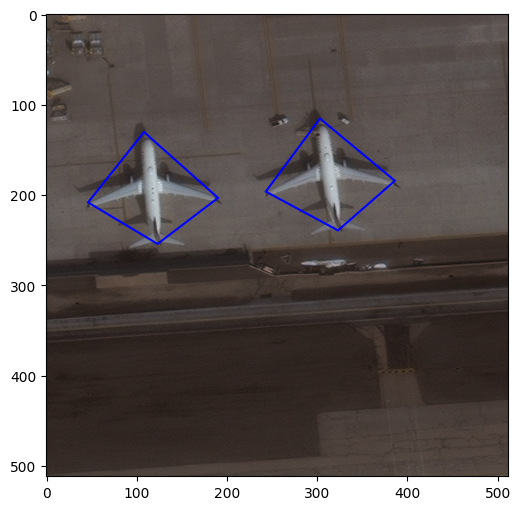

In [11]:
plt.figure(figsize=(6, 6))  # Set the figure size to 10x10 inches

img_title = test_annotations_df['file_name'].iloc[1]
img = plt.imread('/kaggle/input/rareplane-dataset/test/PS-RGB_tiled/' + img_title + '.png')

coors = test_annotations_df[test_annotations_df['file_name'] == img_title]['coordinates'].tolist()

for coor in coors:
    poly = Polygon(coor, fill=False, edgecolor='b', linewidth=1.5)
    plt.gca().add_patch(poly)

plt.imshow(img)

plt.show()

## Load ROI from phase 1

In [92]:
roi_dir = '/kaggle/input/phase1/yolov5/runs/detect/exp/labels/'
img_dir = '/kaggle/input/rareplane-dataset/test/PS-RGB_tiled'

In [13]:
def read_roi(filename):
    filename = os.path.join(roi_dir, f"{filename}.txt")
    with open(filename, 'r') as file:
        lines = file.readlines()

    roi = []

    for line in lines:
        parts = line.strip().split()
        center_x, center_y, width, height  = float(parts[1]), float(parts[2]), float(parts[3]),float(parts[4])
        x_min = max(0, int((center_x - width / 2) * 512))
        y_min = max(0, int((center_y - height / 2) * 512))
        x_max = min(512, int((center_x + width / 2) * 512))
        y_max = min(512, int((center_y + height / 2) * 512))

        roi.append(((x_min, y_min), (x_min, y_max), (x_max, y_min), (x_max, y_max)))

    return roi

bounding_box_points = read_roi('105_104001003108D900_tile_51')
bounding_box_points

[((255, 288), (255, 311), (327, 288), (327, 311)),
 ((360, 293), (360, 318), (421, 293), (421, 318)),
 ((297, 316), (297, 338), (364, 316), (364, 338))]

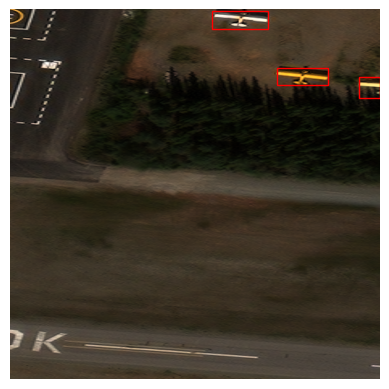

In [14]:
def visualize_image_with_bboxes(image_path, bounding_box_points):
    img = PIL.Image.open(image_path)

    fig, ax = plt.subplots(1)

    ax.imshow(img)
    
    for box in bounding_box_points:
        x_min, y_min = box[0]
        x_max, y_max = box[3]
        bbox_patch = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            fill=False, edgecolor='r', linewidth=1
        )
        ax.add_patch(bbox_patch)

    ax.set_axis_off()
    plt.show()

image_path = '/kaggle/input/rareplane-dataset/test/PS-RGB_tiled/105_104001003108D900_tile_58.png'
bounding_box_points = read_roi('105_104001003108D900_tile_58')
visualize_image_with_bboxes(image_path, bounding_box_points)

## SIFT keypoints extraction
---
- SIFT algorithm to extract keypoints
- Find the 2 furthest points to form a line
- Create a perpendicular line intersecting former line at the middle point
- Got 4 keypoints detected

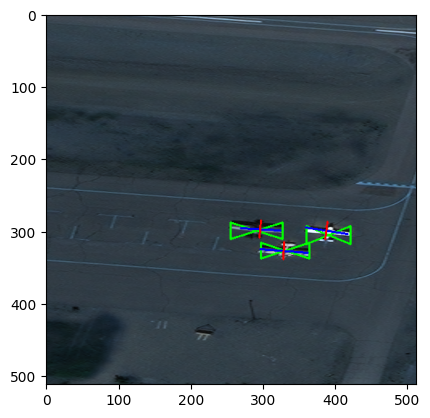

[((324, 299), (269, 296), (297, 285), (295, 309)),
 ((417, 304), (359, 295), (389, 287), (386, 311)),
 ((296, 325), (362, 330), (328, 339), (329, 315))]

In [124]:
import math

def getPerpCoord(aX, aY, bX, bY, length):
    midX, midY = (aX + bX) / 2, (aY + bY) / 2
    
    vX = bX - aX
    vY = bY - aY
    
    if vX == 0 or vY == 0:
        return 0, 0, 0, 0
    
    mag = math.sqrt(vX * vX + vY * vY)
    vX = vX / mag
    vY = vY / mag
    temp = vX
    vX = 0 - vY
    vY = temp
    
    cX = midX + vX * length
    cY = midY + vY * length
    dX = midX - vX * length
    dY = midY - vY * length
    
    return int(cX), int(cY), int(dX), int(dY)

def calculate_midpoint(pt1, pt2):
    return ((pt1[0] + pt2[0]) / 2, (pt1[1] + pt2[1]) / 2)

def select_furthest_keypoints(image, bounding_boxes, num_keypoints=2):
    all_keypoints = []

    for bounding_box in bounding_boxes:
        mask = create_mask(image, bounding_box)

        sift = cv2.SIFT_create(contrastThreshold=0.0001, nfeatures=500, sigma=0.5)
        keypoints_roi, _ = sift.detectAndCompute(image, mask)

        distances = []
        for i, kp1 in enumerate(keypoints_roi):
            for kp2 in keypoints_roi[i + 1:]:
                distances.append((kp1, kp2, calculate_distance(kp1.pt, kp2.pt)))

        distances.sort(key=lambda x: x[2], reverse=True)

        selected_keypoints = [distances[0][0], distances[0][1]]

        all_keypoints.extend(selected_keypoints)

    return all_keypoints

def image_with_keypoints(image_name, bounding_boxes):
    image_path = os.path.join(img_dir, f"{image_name}.png")
    image = cv2.imread(image_path)

    furthest_keypoints = select_furthest_keypoints(image, bounding_boxes, num_keypoints=2)

    for bounding_box in bounding_boxes:
        pts = np.array(bounding_box, np.int32)
        pts = pts.reshape((-1, 1, 2))
        image = cv2.polylines(image, [pts], True, (0, 255, 0), 2)

    points = []
    for i in range(0, len(furthest_keypoints), 2):
        kp1, kp2 = furthest_keypoints[i], furthest_keypoints[i + 1]
        x1, y1 = map(int, kp1.pt)
        x2, y2 = map(int, kp2.pt)

        # Draw a line connecting the two furthest keypoints
        image = cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        length_factor = 12 
        cX, cY, dX, dY = getPerpCoord(x1, y1, x2, y2, length_factor)

        image = cv2.line(image, (cX, cY), (dX, dY), (255, 0, 0), 2)
        
        point = ((x1, y1), (x2, y2), (cX, cY), (dX, dY))
        points.append(point)

    plt.imshow(image)
    plt.show()
    
    return points

poly_points = image_with_keypoints('105_104001003108D900_tile_51', read_roi('105_104001003108D900_tile_51'))
poly_points

In [125]:
# test_annotations_df['poly pt'] = test_annotations_df['file_name'].apply(lambda x: read_roi(x))
# test_annotations_df.head(5)